In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform
from statsmodels.stats import outliers_influence

In [2]:
Beta0 = 10
Beta1 = 2
Sigma = 0.5
N = 20

np.random.seed(111)
XSample = uniform.rvs(0, 1, size=N)
XSample.sort()
Epsilon = norm.rvs(0, Sigma, size=N)

YSample = Beta0 + Beta1 * XSample + Epsilon

In [3]:
Dat = pd.DataFrame({"Y": YSample, "X":XSample})

<Axes: xlabel='X', ylabel='Y'>

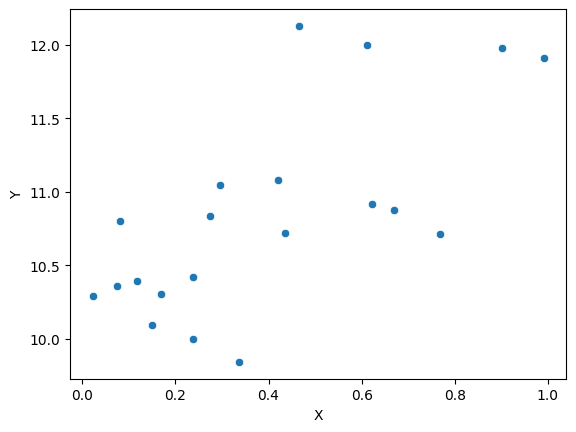

In [4]:
sns.scatterplot(data=Dat, x="X", y="Y")

---

## Regression using sm.OLS

In this case, we need to add a constant to the x variable, otherwise it won't fit an intercept.

In [5]:
RegModel = sm.OLS(YSample, sm.add_constant(Dat["X"]))
RegModelFit = RegModel.fit()

In [6]:
RegModelFit.summary2(alpha=0.11)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.446   
Dependent Variable: y                AIC:                32.0033 
Date:               2024-10-07 13:40 BIC:                33.9947 
No. Observations:   20               Log-Likelihood:     -14.002 
Df Model:           1                F-statistic:        16.27   
Df Residuals:       18               Prob (F-statistic): 0.000779
R-squared:          0.475            Scale:              0.26386 
-------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|    [0.055    0.945]
-------------------------------------------------------------------
const      10.1769     0.1997   50.9693   0.0000   9.8412   10.5125
X           1.6711     0.4143    4.0336   0.0008   0.9746    2.3676
-----------------------------------------------------------------
Omnibus:              1.246        Durbin-Watson:           1.798
Prob(Omnibus):        0.536        Jarque-Bera (JB):        0.464
Skew:                 0.367        Prob(JB):                0.793
Kurtosis:             3.136        Condition No.:           4    
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [7]:
HatSigma = np.sqrt(RegModelFit.mse_resid)
HatSigma

0.5136689761668786

In [8]:
# List with all the attributes of the model
dir(RegModelFit)[:5]

['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', '_HCCM']

Get confidence and prediction intervals

In [9]:
PredictionTable = RegModelFit.get_prediction().summary_frame(alpha=0.11)

In [10]:
PredictionTable.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,10.214438,0.192124,9.891446,10.537430,9.292449,11.136427
1,10.300466,0.175491,10.005437,10.595495,9.387898,11.213035
2,10.312557,0.173236,10.021320,10.603795,9.401207,11.223907
3,10.374681,0.162028,10.102286,10.647077,9.469177,11.280186
4,10.426144,0.153296,10.168428,10.683860,9.524946,11.327342


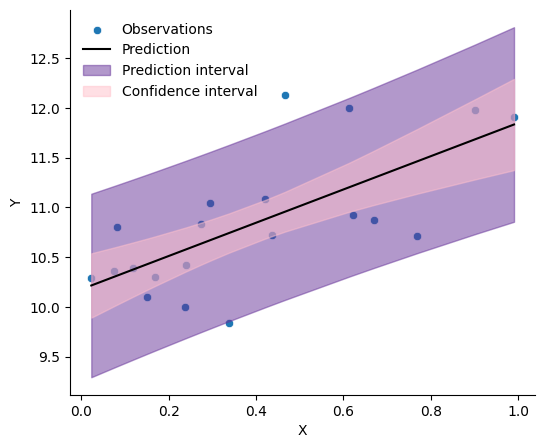

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))

# Scatterplot of the observations
sns.scatterplot(
    data=Dat,
    x="X",
    y="Y",
    ax=ax,
    label="Observations"
)

# Plot predicted mean
ax.plot(
    XSample,
    PredictionTable["mean"],
    color="k",
    label="Prediction"
)

# Plot prediction interval
ax.fill_between(
    XSample,
    PredictionTable["obs_ci_lower"],
    PredictionTable["obs_ci_upper"],
    color="rebeccapurple",
    alpha=0.5,
    label="Prediction interval"
)

# Plot confidence interval
ax.fill_between(
    XSample,
    PredictionTable["mean_ci_lower"],
    PredictionTable["mean_ci_upper"],
    color="pink",
    alpha=0.5,
    label="Confidence interval"
)

ax.legend(frameon=False)
ax.spines[['right', 'top']].set_visible(False)

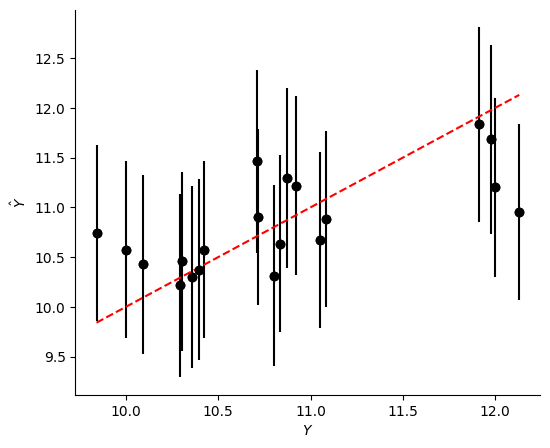

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(YSample, PredictionTable["mean"], color="k")

ax.errorbar(
    YSample,
    PredictionTable["mean"],
    yerr=PredictionTable["obs_ci_upper"] - PredictionTable["mean"],
    fmt="o",
    color="k"
)

ax.plot(
    [YSample.min(), YSample.max()]
    , [YSample.min(), YSample.max()]
    , color='r'
    , linestyle='--'
)

ax.set_xlabel(r"$Y$")
ax.set_ylabel(r"$\hat{Y}$")
ax.spines[['right', 'top']].set_visible(False)

---

We can also get these intervals together with other statistics for outliers and influence analysis.

In [13]:
OutlierTable, OutlierData, OutlierNames = outliers_influence.summary_table(RegModelFit, alpha=0.11)

In [14]:
df = pd.DataFrame.from_records(OutlierTable)
header = df.iloc[0] # grab the first row for the header
df = df[1:] # take the data less the header row
df.columns = header

In [15]:
df.head()

,Obs,Dep Var,Predicted,Std Error,Mean ci,Mean ci,Predict ci,Predict ci,Residual,Std Error,Student,Cook's
1,,Population,Value,Mean Predict,95% low,95% upp,95% low,95% upp,,Residual,Residual,D
2,1.0,10.290958150459195,10.214438237142806,0.19212392563741335,9.891446296702268,10.537430177583344,9.292449472453823,11.13642700183179,0.07651991331638897,0.47638662268581694,0.16062565502989537,0.0020981842194241216
3,2.0,10.360251228980335,10.300466470452955,0.17549085953239374,10.005437451751144,10.595495489154766,9.387897782353628,11.213035158552282,0.05978475852738008,0.4827616133216382,0.12383908926816163,0.0010132790080957489
4,3.0,10.80390972659004,10.312557217558513,0.17323566126465537,10.02131955832512,10.603794876791907,9.401207195460023,11.223907239657004,0.49135250903152716,0.48357545713417555,1.0160823957928737,0.0662481801559318
5,4.0,10.394728729311534,10.37468143471091,0.16202803475923372,10.102285640282792,10.647077229139027,9.469176626636816,11.280186242785003,0.02004729460062471,0.48744510770792415,0.04112728650594437,9.344563393912305e-05


---

## Regression using smf.ols

In this case, it adds a constant to the x variable automatically.

In [16]:
RegModel = smf.ols(data=Dat, formula="Y ~ X")
RegModelFit = RegModel.fit()

In [17]:
RegModelFit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.446   
Dependent Variable: Y                AIC:                32.0033 
Date:               2024-10-07 13:40 BIC:                33.9947 
No. Observations:   20               Log-Likelihood:     -14.002 
Df Model:           1                F-statistic:        16.27   
Df Residuals:       18               Prob (F-statistic): 0.000779
R-squared:          0.475            Scale:              0.26386 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|   [0.025   0.975]
------------------------------------------------------------------
Intercept      10.1769    0.1997  50.9693  0.0000  9.7574  10.5964
X               1.6711    0.4143   4.0336  0.0008  0.8007   2.5415
-----------------------------------------------------------------
Omnibus:              1.246        Durbin-Watson:           1.798
Prob(Omnibus):        0.536        Jarque-Bera (JB):        0.464
Skew:                 0.367        Prob(JB):                0.793
Kurtosis:             3.136        Condition No.:           4    
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""